
# **Recurrence Type prediction**

local / distant prediction

# Datasets
**Training dataset:**

1.   Metabric Breast Cancer dataset
2.   Duke university Breast Cancer dataset
3.   MSK Breast Cancer dataset
4.   SEER dataset


**Validation dataset:** Real patients from Baheya hospital

# **0. Import Required Libraries**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import joblib

# **See insights about Target first**

In [ ]:
seer = pd.read_csv('SEER.csv')

In [ ]:
seer['SEER Combined Summary Stage 2000 (2004+)'].value_counts()


SEER Combined Summary Stage 2000 (2004+)
Localized only                                                  1868
Regional lymph nodes involved only                               653
Distant site(s)/node(s) involved                                 151
Regional by both direct extension and lymph node involvement      81
Regional by direct extension only                                 49
Unknown/unstaged/unspecified/DCO                                  23
Name: count, dtype: int64

In [ ]:
# see the local characteristics
local_recurrence_data = seer[seer['SEER Combined Summary Stage 2000 (2004+)'].str.startswith('Regional')]

tumor_size_counts = local_recurrence_data['Derived AJCC T, 7th ed (2010-2015)'].value_counts()

lymph_node_status_counts = local_recurrence_data['Derived AJCC N, 7th ed (2010-2015)'].value_counts()


print("Tumor Size Distribution for Regional Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Regional Recurrence Patients:")
print(lymph_node_status_counts)


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
# see the local characteristics

local_recurrence_data = seer[seer['SEER Combined Summary Stage 2000 (2004+)'].str.startswith('Distant site(s)/node(s) involved')]

tumor_size_counts = local_recurrence_data['Derived AJCC T, 7th ed (2010-2015)'].value_counts()

lymph_node_status_counts = local_recurrence_data['Derived AJCC N, 7th ed (2010-2015)'].value_counts()

print("Tumor Size Distribution for Distant Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Distant Recurrence Patients:")
print(lymph_node_status_counts)


Tumor Size Distribution for Distant Recurrence Patients:
Derived AJCC T, 7th ed (2010-2015)
T2       5600
TX       3826
T4b      3273
T3       2950
T1c      1783
T4d      1696
T4a       812
T1b       514
T0        513
T4c       272
T4NOS     177
T1a       116
T1NOS      33
T1mic      25
Name: count, dtype: int64

Lymph Node Status Distribution for Distant Recurrence Patients:
Derived AJCC N, 7th ed (2010-2015)
N1          6802
N0          4929
NX          2706
N3c         1693
N2a         1519
N1a         1011
N3a          977
N3b          532
N2NOS        374
N1NOS        305
N1mi         191
N0(i-)       186
N3NOS        179
N2b          137
N0(i+)        35
N1c            6
N1b            4
N0(mol-)       3
N0(mol+)       1
Name: count, dtype: int64


In [ ]:
# see the local characteristics

local_recurrence_data = seer[seer['SEER Combined Summary Stage 2000 (2004+)'].str.startswith('Localized')]

tumor_size_counts = local_recurrence_data['Derived AJCC T, 7th ed (2010-2015)'].value_counts()

lymph_node_status_counts = local_recurrence_data['Derived AJCC N, 7th ed (2010-2015)'].value_counts()


print("Tumor Size Distribution for Localized Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Localized Recurrence Patients:")
print(lymph_node_status_counts)

Tumor Size Distribution for Localized Recurrence Patients:
Derived AJCC T, 7th ed (2010-2015)
T1c      87980
T1b      53560
T2       53360
T1a      23279
T1mic     6388
T3        5960
TX        3788
Tis        504
T1NOS      475
Name: count, dtype: int64

Lymph Node Status Distribution for Localized Recurrence Patients:
Derived AJCC N, 7th ed (2010-2015)
N0          140985
N0(i-)       84551
N0(i+)        7073
NX            2135
N0(mol-)       503
N0(mol+)        47
Name: count, dtype: int64




# **1.1. Reading General merged data**

In [ ]:
data= pd.read_csv('Final_general_merged.csv')
data.head()

<ipython-input-12-cc449c3cede1>:1: DtypeWarning: Columns (0,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('Final_general_merged.csv')


Menopausal Status Tumor Size Lymph Node Status Tumor Grade Mol Subtype  \
0              Post         T2                N3         III   Luminal A   
1               Pre         T1                N0         III   Luminal A   
2               Pre         T1                N1          II   Luminal B   
3               Pre         T2                N1          II   Luminal B   
4              Post         T2                N2         III   Luminal B   

                         Histological Type        ER        PR      HER2  \
0              Infiltrating duct carcinoma  Positive  Negative  Negative   
1              Infiltrating duct carcinoma  Positive  Positive  Negative   
2              Infiltrating duct carcinoma  Positive  Positive  Negative   
3  Infiltrating duct and lobular carcinoma  Positive  Positive  Negative   
4  Infiltrating duct and lobular carcinoma  Positive  Positive  Negative   

  Chemotherapy  ... Overall Survival Status (Month)  \
0           No  ...                      140.500000   
1           No  ...                       84.633333   
2          Yes  ...                      163.700000   
3          Yes  ...                      164.933333   
4          Yes  ...                       41.366667   

  Recurrence Free Status (Month) Recurrence Free Status          Age  Surgery  \
0                         138.65         Not Recurrence  75-79 years      NaN   
1                          83.52         Not Recurrence  40-44 years      NaN   
2                         151.28             Recurrence  45-49 years      NaN   
3                         162.76         Not Recurrence  45-49 years      NaN   
4                          18.55             Recurrence  75-79 years      NaN   

  Recurrence_Type Bone_metastasis Brain_metastasis Lung_metastasis  \
0             NaN             NaN              NaN             NaN   
1             NaN             NaN              NaN             NaN   
2             NaN             NaN              NaN             NaN   
3             NaN             NaN              NaN             NaN   
4             NaN             NaN              NaN             NaN   

  Liver_metastasis  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 23 columns]

In [ ]:
data.columns

Index(['Menopausal Status', 'Tumor Size', 'Lymph Node Status', 'Tumor Grade',
       'Mol Subtype', 'Histological Type', 'ER', 'PR', 'HER2', 'Chemotherapy',
       'Radiotherapy', 'Type of Surgery', 'Tumor Location',
       'Overall Survival Status (Month)', 'Recurrence Free Status (Month)',
       'Recurrence Free Status', 'Age', 'Surgery', 'Recurrence_Type',
       'Bone_metastasis', 'Brain_metastasis', 'Lung_metastasis',
       'Liver_metastasis'],
      dtype='object')

In [ ]:
data = data[ (data['Histological Type'] != 'Metaplastic carcinoma') &  (data['Histological Type'] != 'Cribriform carcinoma') & (data['Histological Type'] != 'Mucinous adenocarcinoma')]

# **1.2. Data selection from general data**

In [ ]:
selected_data = data[['Tumor Size','Recurrence_Type', 'Lymph Node Status', 'Tumor Grade', 'Mol Subtype', 'ER', 'HER2']]

# **1.3. Data Balancing**


In [ ]:
selected_data['Recurrence_Type'].value_counts()

Recurrence_Type
Local      170745
Distant     11024
Normal       1086
Name: count, dtype: int64

In [ ]:
selected_data = selected_data[(selected_data['Recurrence_Type'] != 'Normal') ]

In [ ]:
selected_data['Recurrence_Type'].value_counts()

Recurrence_Type
Local      170745
Distant     11024
Name: count, dtype: int64

In [ ]:
# Function to sample each group
def sample_group(group, n):
    if len(group) < n:
        return group
    return group.sample(n)

balanced_data = selected_data.groupby('Recurrence_Type', group_keys=False).apply(lambda x: sample_group(x, 11181)).reset_index(drop=True)

print(balanced_data['Recurrence_Type'].value_counts())


Recurrence_Type
Local      11181
Distant    11024
Name: count, dtype: int64


In [ ]:
balanced_data.isna().sum()

Tumor Size           0
Recurrence_Type      0
Lymph Node Status    0
Tumor Grade          0
Mol Subtype          0
ER                   0
HER2                 0
dtype: int64

In [ ]:
#Show unique values
categorical_columns = balanced_data.select_dtypes(include='object').columns
unique_counts = {}

for column_name in categorical_columns:
    unique_counts[column_name] = balanced_data[column_name].value_counts()

for column_name, counts in unique_counts.items():
    print(f"Unique values for '{column_name}':")
    print(counts)
    print()

Unique values for 'Tumor Size':
Tumor Size
T1    10195
T2     6504
T4     3241
T3     2255
T0       10
Name: count, dtype: int64

Unique values for 'Recurrence_Type':
Recurrence_Type
Local      11181
Distant    11024
Name: count, dtype: int64

Unique values for 'Lymph Node Status':
Lymph Node Status
N0    13738
N1     4763
N3     2261
N2     1443
Name: count, dtype: int64

Unique values for 'Tumor Grade':
Tumor Grade
II     9444
III    9004
I      3757
Name: count, dtype: int64

Unique values for 'Mol Subtype':
Mol Subtype
Luminal A          15128
Luminal B           2888
Triple Negative     2798
HER2 enriched       1391
Name: count, dtype: int64

Unique values for 'ER':
ER
Positive    17721
Negative     4484
Name: count, dtype: int64

Unique values for 'HER2':
HER2
Negative    17926
Positive     4279
Name: count, dtype: int64



In [ ]:
# see the local characteristics

local_recurrence_data = balanced_data[balanced_data['Recurrence_Type'] == 'Local']

tumor_size_counts = local_recurrence_data['Tumor Size'].value_counts()

lymph_node_status_counts = local_recurrence_data['Lymph Node Status'].value_counts()

tumor_grade_counts = local_recurrence_data['Tumor Grade'].value_counts()

print("Tumor Size Distribution for Local Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Local Recurrence Patients:")
print(lymph_node_status_counts)

print("\nTumor Grade Distribution for Local Recurrence Patients:")
print(tumor_grade_counts)


Tumor Size Distribution for Local Recurrence Patients:
Tumor Size
T1    8331
T2    2590
T3     260
Name: count, dtype: int64

Lymph Node Status Distribution for Local Recurrence Patients:
Lymph Node Status
N0    11181
Name: count, dtype: int64

Tumor Grade Distribution for Local Recurrence Patients:
Tumor Grade
II     5047
III    3175
I      2959
Name: count, dtype: int64


In [ ]:
# see the local characteristics

distant_recurrence_data = balanced_data[balanced_data['Recurrence_Type'] == 'Distant']

tumor_size_counts = distant_recurrence_data['Tumor Size'].value_counts()

lymph_node_status_counts = distant_recurrence_data['Lymph Node Status'].value_counts()

tumor_grade_counts = distant_recurrence_data['Tumor Grade'].value_counts()

print("Tumor Size Distribution for Distant Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Distant Recurrence Patients:")
print(lymph_node_status_counts)

print("\nTumor Grade Distribution for Distant Recurrence Patients:")
print(tumor_grade_counts)


Tumor Size Distribution for Distant Recurrence Patients:
Tumor Size
T2    3914
T4    3241
T3    1995
T1    1864
T0      10
Name: count, dtype: int64

Lymph Node Status Distribution for Distant Recurrence Patients:
Lymph Node Status
N1    4763
N0    2557
N3    2261
N2    1443
Name: count, dtype: int64

Tumor Grade Distribution for Distant Recurrence Patients:
Tumor Grade
III    5829
II     4397
I       798
Name: count, dtype: int64




---







---



## **2. Feature Engineering**




## **2.1. Prepare features and target variable**

In [ ]:
X = balanced_data.drop(columns=['Recurrence_Type'],axis=1)
y = balanced_data['Recurrence_Type']

In [ ]:
X

Tumor Size Lymph Node Status Tumor Grade      Mol Subtype        ER  \
0             T3                N2         III  Triple Negative  Negative   
1             T2                N2         III  Triple Negative  Negative   
2             T4                N1         III  Triple Negative  Negative   
3             T4                N3          II  Triple Negative  Negative   
4             T1                N1         III        Luminal B  Positive   
...          ...               ...         ...              ...       ...   
22200         T1                N0          II        Luminal A  Positive   
22201         T1                N0           I        Luminal A  Positive   
22202         T1                N0          II        Luminal A  Positive   
22203         T1                N0         III        Luminal A  Positive   
22204         T1                N0          II        Luminal A  Positive   

           HER2  
0      Negative  
1      Negative  
2      Negative  
3      Negative  
4      Positive  
...         ...  
22200  Negative  
22201  Negative  
22202  Negative  
22203  Negative  
22204  Negative  

[22205 rows x 6 columns]

## **2.2 Encoding**

**Features**

In [ ]:
X = pd.get_dummies(X, columns=['Tumor Size'	,'Lymph Node Status','Tumor Grade'	,'Mol Subtype'	,	'ER'	,'HER2'])

**Target**

In [ ]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

In [ ]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

0: Distant
1: Local


**Feature Importance**

In [ ]:
mi_scores = mutual_info_classif(X, y)

mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

print(mi_scores_df)


                        Feature  Mutual Information Score
5          Lymph Node Status_N0                  0.401898
6          Lymph Node Status_N1                  0.180330
1                 Tumor Size_T1                  0.178472
4                 Tumor Size_T4                  0.114123
8          Lymph Node Status_N3                  0.075469
7          Lymph Node Status_N2                  0.047642
3                 Tumor Size_T3                  0.041681
9                 Tumor Grade_I                  0.034454
11              Tumor Grade_III                  0.032691
19                HER2_Positive                  0.019083
2                 Tumor Size_T2                  0.017867
13        Mol Subtype_Luminal A                  0.015883
18                HER2_Negative                  0.011865
14        Mol Subtype_Luminal B                  0.006923
15  Mol Subtype_Triple Negative                  0.006039
10               Tumor Grade_II                  0.005031
12    Mol Subt

## **2.3 Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

## **3. Model Training & Evaluation**




### **XGBoost Model**

In [ ]:
XG = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [1, 3, 5, 7, 10],
    'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(estimator=XG, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_result.best_params_)

best_XG = grid_result.best_estimator_

y_pred = best_XG.predict(X_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}


In [ ]:
y_train_pred = best_XG.predict(X_train)

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.9071607797722447
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9007805463824677
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3307
           1       0.85      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



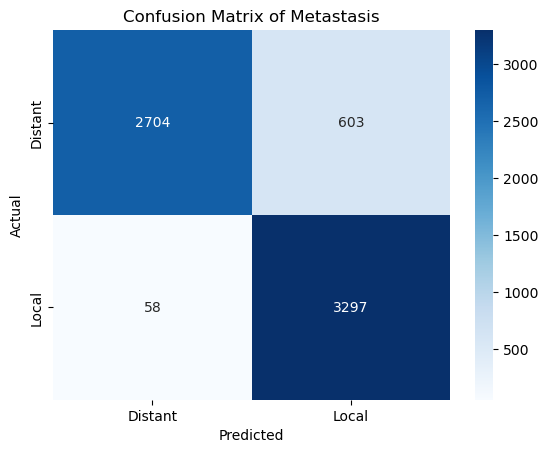

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

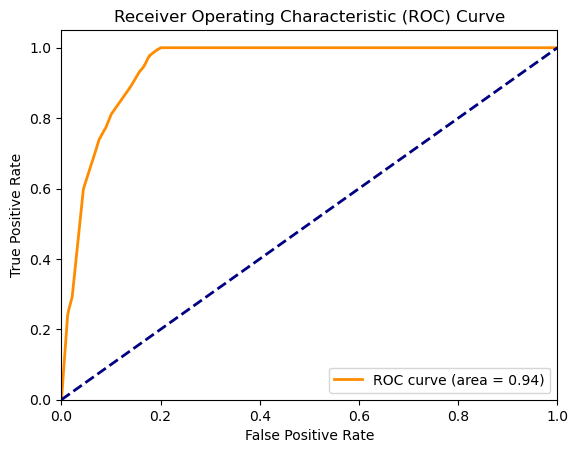

In [ ]:
# Make predictions and compute ROC curve
y_pred_prob = best_XG.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
joblib.dump(best_XG, 'model_locdis_XG.pkl')

['model_locdis_XG.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **Random Forest Model**

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
}

RF = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params)

# Make predictions
y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:  {'max_depth': None, 'n_estimators': 300}


In [ ]:
y_train_pred = best_rf.predict(X_train)

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.9075468056359776
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9012308616031222
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3307
           1       0.85      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



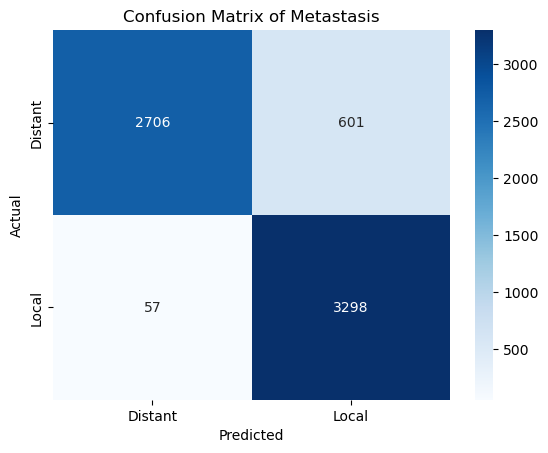

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

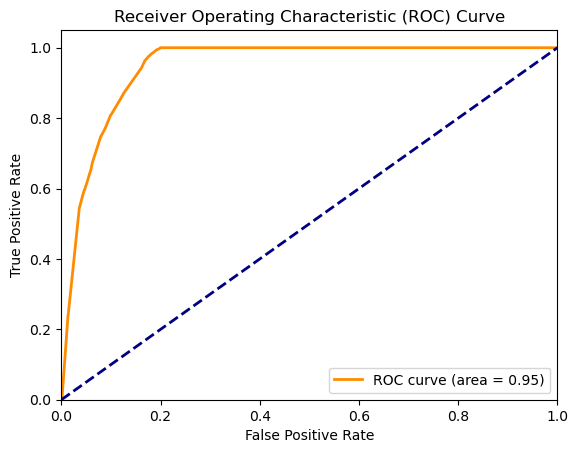

In [ ]:
# Make predictions and compute ROC curve
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
joblib.dump(best_rf, 'model_locdis_rf.pkl')

['model_locdis_rf.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **SVM Model**

In [ ]:
SVM = SVC(kernel='rbf', C=1000, gamma=0.1)

SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

In [ ]:
y_train_pred = SVM.predict(X_train)

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.9075468056359776
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9012308616031222
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3307
           1       0.85      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



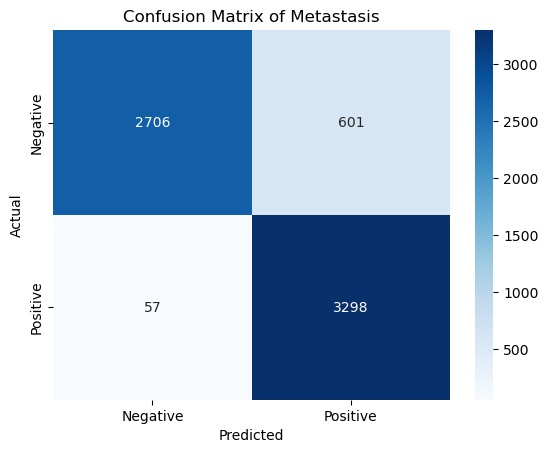

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

In [ ]:
joblib.dump(SVM, 'model_locdis_SV.pkl')

['model_locdis_SV.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **NN Model**

In [ ]:
# Define the neural network model
model_Mets_NN = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # To capture non-linear complex relations
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])

model_Mets_NN.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002), metrics=['accuracy'])

history = model_Mets_NN.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

y_train_pred = model_Mets_NN.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

c:\Users\nadat\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training Set Accuracy: 0.9074824679920221
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [ ]:
y_test_pred = model_Mets_NN.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing Set Accuracy: 0.9007805463824677
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3307
           1       0.85      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



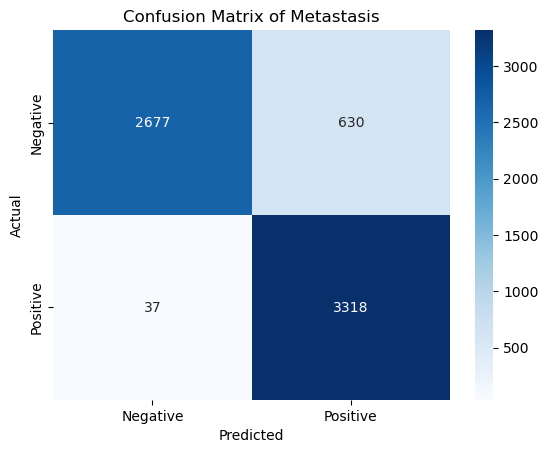

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________





**LGB**

In [ ]:
param_grid_lgb = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1]
}


model = lgb.LGBMClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_lgb, cv=3)
grid_result = grid_search.fit(X_train, y_train)

best_lgb = grid_result.best_estimator_

best_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5217, number of negative: 5145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 10362, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503474 -> initscore=0.013897
[LightGBM] [Info] Start training from score 0.013897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(learning_rate=0.01, max_depth=10)

In [ ]:
# Make predictions on the test set
y_pred = best_lgb.predict(X_train)

Train_accuracy_lgbm = accuracy_score(y_train, y_pred)
train_report = classification_report(y_train, y_pred)
print("Accuracy:", Train_accuracy_lgbm)
print("Training Set Classification Report:\n", train_report)

y_test_pred = best_lgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.9071607797722447
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Testing Set Accuracy: 0.9009306514560192
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3307
           1       0.85      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      666

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_lgb, X_train, y_train, cv=10, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7043, number of negative: 6945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 13988, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503503 -> initscore=0.014012
[LightGBM] [Info] Start training from score 0.014012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [ ]:
joblib.dump(best_lgb, 'model_locdis_lgb.pkl')

['model_locdis_lgb.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________

**KNN**

In [ ]:
# Ensure the arrays are contiguous
X_train_contiguous = np.ascontiguousarray(X_train)
y_train_contiguous = np.ascontiguousarray(y_train)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train_contiguous, y_train_contiguous)

best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

print("Best Parameters:", best_params)

best_knn.fit(X_train_contiguous, y_train_contiguous)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}


KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='distance')

In [ ]:
# Make predictions on the training set
y_train_pred = best_knn.predict(X_train_contiguous)
train_accuracy = accuracy_score(y_train_contiguous, y_train_pred)
train_report = classification_report(y_train_contiguous, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

# Ensure the arrays are contiguous
X_test_contiguous = np.ascontiguousarray(X_test)
y_test_contiguous = np.ascontiguousarray(y_test)

y_test_pred = best_knn.predict(X_test_contiguous)
test_accuracy = accuracy_score(y_test_contiguous, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


Training Set Accuracy: 0.9058740268931351
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543

Testing Set Accuracy: 0.8998799159411588
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      3307
           1       0.84      0.99      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



In [ ]:
joblib.dump(best_knn, 'model_locdis_KNN.pkl')

['model_locdis_KNN.pkl']

**Combined Train Test ROC**

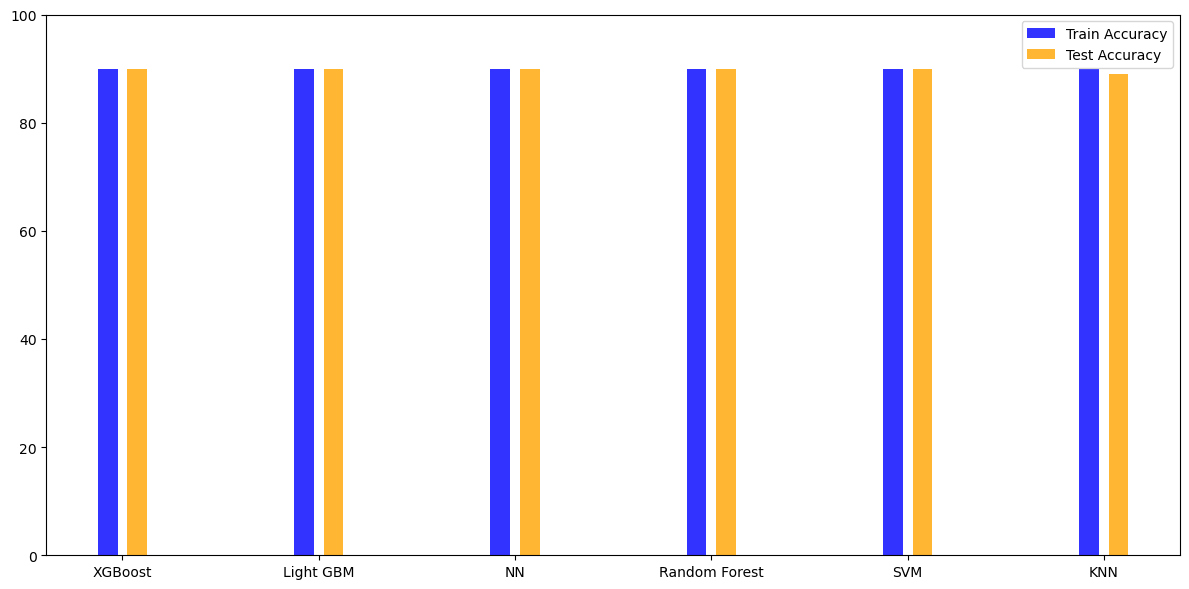

In [ ]:
models = ['XGBoost', 'Light GBM', 'NN', 'Random Forest', 'SVM', 'KNN']
metrics = ['Train Accuracy', 'Test Accuracy']
values = np.array([
    [90, 90, 90, 90, 90, 90],
    [90, 90, 90, 90, 90, 89]
])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1  # thinner bars
opacity = 0.8
space = 0.05  # space between the bars
colors = ['blue', 'orange']

for i, metric in enumerate(metrics):
    rects = ax.bar(np.arange(len(models)) + (i * (bar_width + space)), values[i], bar_width,
                   alpha=opacity, color=colors[i], label=metric)

ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100

ax.set_xticks(np.arange(len(models)) + ((len(metrics) - 1) * (bar_width + space)) / 2)  # Center x-ticks
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.savefig('Train_Test_LocDist.svg', format='svg')
plt.show()


# __________________________________________________________________________________________________________________________________

# **Baheya validation**

In [ ]:
Baheya_data = pd.read_csv('Final_Baheya_Merged.csv')
Baheya_data.head()

Menopausal Status Tumor Size Lymph Node Status Tumor Location  \
0              Post         T3                N1          Right   
1              Post         T2                N1           Left   
2              Post         T2                N2           Left   
3               Pre         T4                N2          Right   
4              Post         T4                N2          Right   

             Histological Type Tumor Grade        ER        PR      HER2  \
0  Infiltrating duct carcinoma          II  Positive  Positive  Negative   
1  Infiltrating duct carcinoma          II  Negative  Negative  Positive   
2  Infiltrating duct carcinoma          II  Positive  Positive  Negative   
3  Infiltrating duct carcinoma          II  Positive  Positive  Negative   
4  Infiltrating duct carcinoma          II  Positive  Positive  Negative   

     Mol Subtype  Recurrence Free Status (Month)  \
0      Luminal A                            27.0   
1  HER2 enriched                            99.0   
2      Luminal A                            97.0   
3      Luminal A                            95.0   
4      Luminal A                            83.0   

   Overall Survival Status (Month) Recurrence_Type Recurrence Free Status  
0                             32.0          Normal         Not Recurrence  
1                             99.0          Normal         Not Recurrence  
2                             97.0          Normal         Not Recurrence  
3                             96.0          Normal         Not Recurrence  
4                             88.0          Normal         Not Recurrence

In [ ]:
Baheya_data = Baheya_data.drop(columns=['Menopausal Status','Recurrence Free Status (Month)','Overall Survival Status (Month)'	,'Recurrence Free Status','Menopausal Status', 'Tumor Location','PR','Histological Type'],axis=1)


In [ ]:
Baheya_data['Recurrence_Type'].value_counts()

Recurrence_Type
Distant    267
Normal     152
Local       49
Name: count, dtype: int64

In [ ]:
Baheya_data = Baheya_data[Baheya_data['Recurrence_Type'] != 'Normal']

**see local charteristics**

In [ ]:
# see the local characteristics

local_recurrence_data = Baheya_data[Baheya_data['Recurrence_Type'] == 'Local']

tumor_size_counts = local_recurrence_data['Tumor Size'].value_counts()

lymph_node_status_counts = local_recurrence_data['Lymph Node Status'].value_counts()

tumor_grade_counts = local_recurrence_data['Tumor Grade'].value_counts()

print("Tumor Size Distribution for Local Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Local Recurrence Patients:")
print(lymph_node_status_counts)

print("\nTumor Grade Distribution for Local Recurrence Patients:")
print(tumor_grade_counts)


Tumor Size Distribution for Local Recurrence Patients:
Tumor Size
T2    17
T4    13
T3    11
T1     8
Name: count, dtype: int64

Lymph Node Status Distribution for Local Recurrence Patients:
Lymph Node Status
N0    20
N1    18
N2     6
N3     5
Name: count, dtype: int64

Tumor Grade Distribution for Local Recurrence Patients:
Tumor Grade
II     28
III    20
I       1
Name: count, dtype: int64


**see distant charteristics**

In [ ]:
# see the local characteristics

distant_recurrence_data = Baheya_data[Baheya_data['Recurrence_Type'] == 'Distant']

# Get counts for each unique value in Tumor Size for local recurrence
tumor_size_counts = distant_recurrence_data['Tumor Size'].value_counts()

# Get counts for each unique value in Lymph Node Status for local recurrence
lymph_node_status_counts = distant_recurrence_data['Lymph Node Status'].value_counts()

# Get counts for each unique value in Tumor Grade for local recurrence
tumor_grade_counts = distant_recurrence_data['Tumor Grade'].value_counts()

print("Tumor Size Distribution for Distant Recurrence Patients:")
print(tumor_size_counts)

print("\nLymph Node Status Distribution for Distant Recurrence Patients:")
print(lymph_node_status_counts)

print("\nTumor Grade Distribution for Distant Recurrence Patients:")
print(tumor_grade_counts)


Tumor Size Distribution for Distant Recurrence Patients:
Tumor Size
T4    99
T2    97
T3    54
T1    17
Name: count, dtype: int64

Lymph Node Status Distribution for Distant Recurrence Patients:
Lymph Node Status
N1    119
N2     53
N0     48
N3     47
Name: count, dtype: int64

Tumor Grade Distribution for Distant Recurrence Patients:
Tumor Grade
II     196
III     62
I        9
Name: count, dtype: int64


In [ ]:
filtered_data = Baheya_data[(Baheya_data['Recurrence_Type'] == 'Local') & (Baheya_data['Tumor Size'] == 'T4')]
row_count = filtered_data.shape[0]
row_count

13

In [ ]:
# remove data
condition1 = (Baheya_data['Recurrence_Type'] == 'Local') & (Baheya_data['Tumor Size'] == 'T4')
Baheya_data = Baheya_data[~condition1]

condition2 = (Baheya_data['Recurrence_Type'] == 'Local') & (Baheya_data['Lymph Node Status'] != 'N0')
Baheya_data = Baheya_data[~condition2]

In [ ]:
Baheya_data['Recurrence_Type'].value_counts()

Recurrence_Type
Distant    267
Local       19
Name: count, dtype: int64

In [ ]:
X_val_Mets = Baheya_data.drop(columns=['Recurrence_Type'],axis=1)
y_val_Mets = Baheya_data['Recurrence_Type']

In [ ]:
X_val_Mets = pd.get_dummies(X_val_Mets, columns=['Tumor Size','Lymph Node Status','Tumor Grade'	,'Mol Subtype'	,'ER','HER2'])

In [ ]:
y_val_Mets = label_encoder.transform(y_val_Mets)

In [ ]:
X_val_Mets.insert(0,'Tumor Size_T0', 0)

**XGBoost**

In [ ]:
y_pred_val_XG = best_XG.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_XG)
val_report = classification_report(y_val_Mets, y_pred_val_XG)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.8671328671328671
Val Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       267
           1       0.32      0.89      0.47        19

    accuracy                           0.87       286
   macro avg       0.66      0.88      0.70       286
weighted avg       0.95      0.87      0.89       286



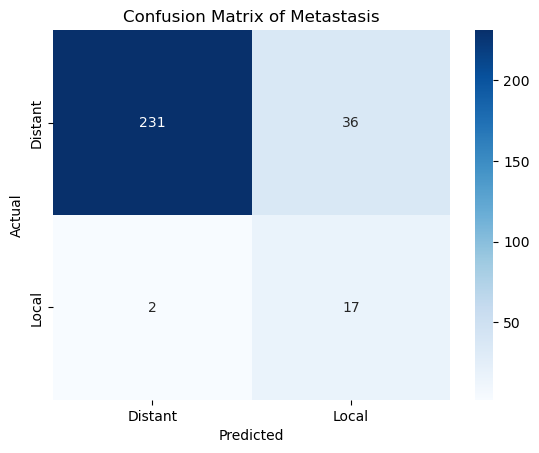

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_XG)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**Random Forest**

In [ ]:
y_pred_val_rf = best_rf.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_rf)
val_report = classification_report(y_val_Mets, y_pred_val_rf)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.8671328671328671
Val Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       267
           1       0.32      0.89      0.47        19

    accuracy                           0.87       286
   macro avg       0.66      0.88      0.70       286
weighted avg       0.95      0.87      0.89       286



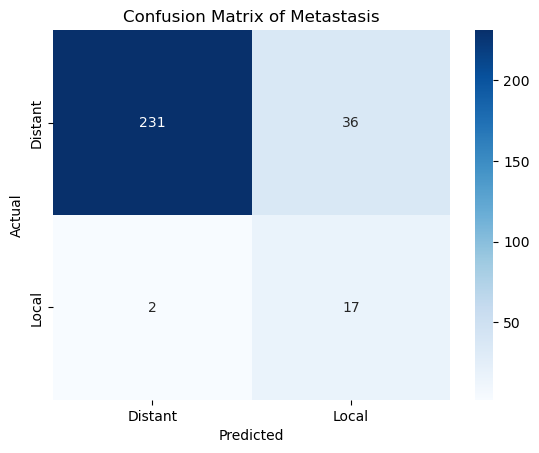

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_rf)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**SVM**

In [ ]:
y_pred_val_SVM = SVM.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_SVM)
val_report = classification_report(y_val_Mets, y_pred_val_SVM)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.8671328671328671
Val Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       267
           1       0.32      0.89      0.47        19

    accuracy                           0.87       286
   macro avg       0.66      0.88      0.70       286
weighted avg       0.95      0.87      0.89       286



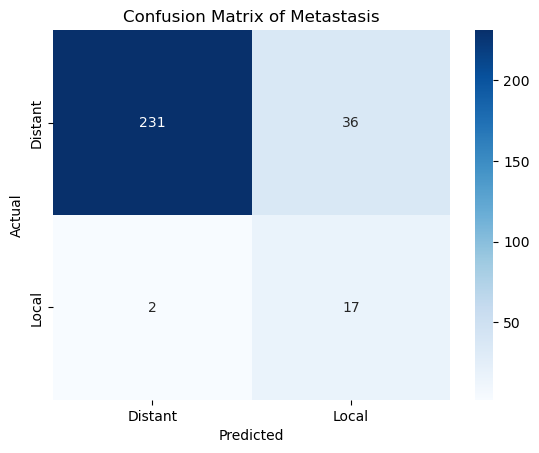

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_SVM)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**NN**

In [ ]:
import numpy as np

y_val = np.array(y_val_Mets)  # Convert y_val to a NumPy array if it's not already

# Ensure X_val_scaled contains only float values
X_val_Mets = X_val_Mets.astype(np.float32)

# Predict on the validation set
y_pred_NN = model_Mets_NN.predict(X_val_Mets)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_Mets_NN.evaluate(X_val_Mets, y_val_Mets)

# Generate classification report
val_report = classification_report(y_val, (y_pred_NN > 0.5).astype(int))

# Print validation metrics
print(f"Validation Loss: {val_loss:.4f}")
print("Validation Set Accuracy:", val_accuracy)
print("Validation Set Classification Report:\n", val_report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8889 - loss: 0.1776 
Validation Loss: 0.2066
Validation Set Accuracy: 0.867132842540741
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92       267
           1       0.32      0.89      0.47        19

    accuracy                           0.87       286
   macro avg       0.66      0.88      0.70       286
weighted avg       0.95      0.87      0.89       286



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


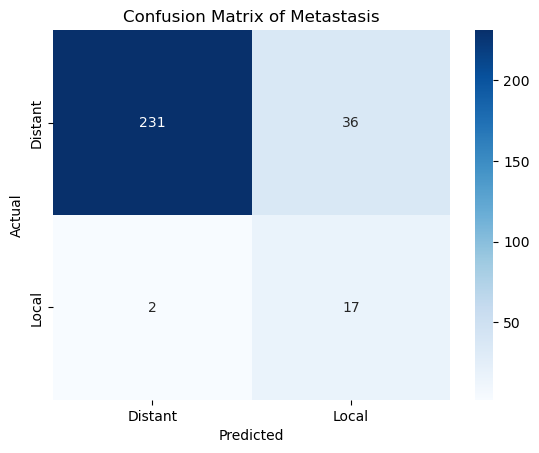

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
y_val_pred = (model_Mets_NN.predict(X_val_Mets) > 0.5).astype(int)

conf_matrix = confusion_matrix(y_val_Mets, y_val_pred)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**LGB**

In [ ]:
y_pred_val_lg = best_lgb.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_lg)
val_report = classification_report(y_val_Mets, y_pred_val_lg)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

Val Accuracy: 0.8671328671328671
Val Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       267
           1       0.32      0.89      0.47        19

    accuracy                           0.87       286
   macro avg       0.66      0.88      0.70       286
weighted avg       0.95      0.87      0.89       286



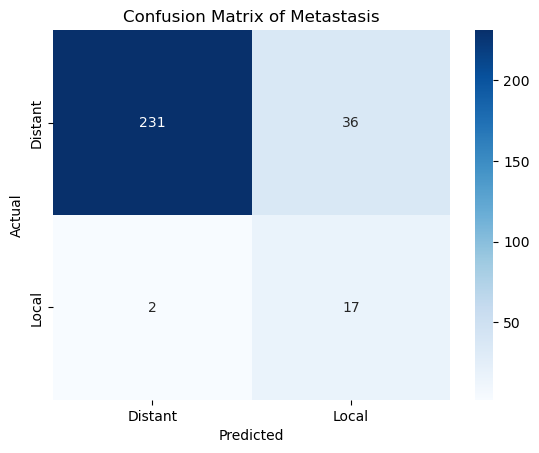

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_lg)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**KNN Validation**

In [ ]:
# Make predictions on the validation set
y_val_pred_knn = best_knn.predict(X_val_Mets)
val_accuracy = accuracy_score(y_val_Mets, y_val_pred_knn)
val_report = classification_report(y_val_Mets, y_val_pred_knn)

print("Validation Set Accuracy:", val_accuracy)
print("Validation Set Classification Report:\n", val_report)

Validation Set Accuracy: 0.8636363636363636
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       267
           1       0.31      0.89      0.47        19

    accuracy                           0.86       286
   macro avg       0.65      0.88      0.69       286
weighted avg       0.95      0.86      0.89       286



c:\Users\nadat\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


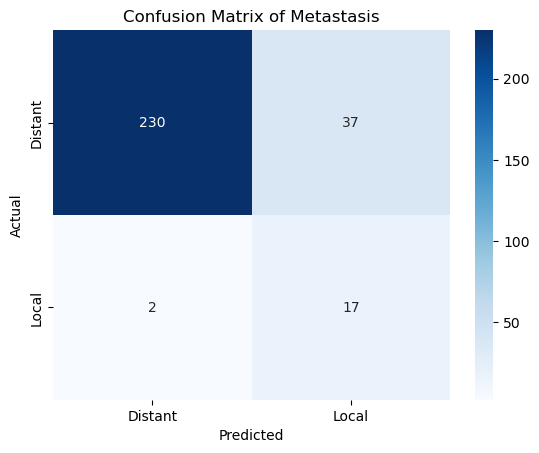

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_val_pred_knn)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**Combined ROC**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\nadat\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


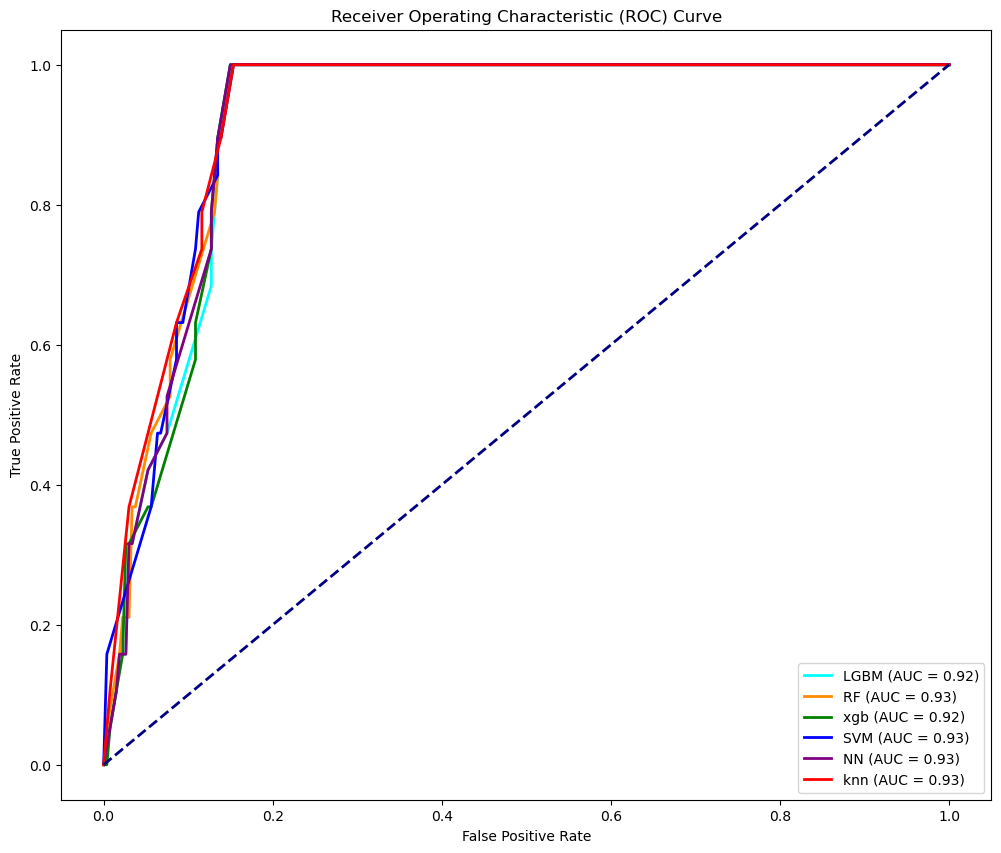

In [ ]:
# Plot ROC curve for clf
y_val_pred_proba_clf = best_rf.predict_proba(X_val_Mets)[:, 1]
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_val_Mets, y_val_pred_proba_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)


# Plot ROC curve for xgb
y_val_pred_proba_xgb = best_XG.predict_proba(X_val_Mets)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val_Mets, y_val_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


# Plot ROC curve for SVM
y_val_pred_proba_svm = SVM.predict_proba(X_val_Mets)[:, 1] if hasattr(SVM, 'predict_proba') else SVM.decision_function(X_val_Mets)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val_Mets, y_val_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Predict probabilities on the validation set
y_val_pred_proba_lgb = best_lgb.predict_proba(X_val_Mets)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_val_Mets, y_val_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# Plot ROC curve for model
y_val_pred_proba_model = model_Mets_NN.predict(X_val_Mets)[:, 0]
fpr_model, tpr_model, thresholds_model = roc_curve(y_val_Mets, y_val_pred_proba_model)
roc_auc_model = auc(fpr_model, tpr_model)

# Plot ROC curve for knn
y_val_pred_proba_knn = best_knn.predict_proba(X_val_Mets)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_val_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)


plt.figure(figsize=(12, 10))

plt.plot(fpr_lgb, tpr_lgb, color='cyan', lw=2, label='LGBM (AUC = {:.2f})'.format(roc_auc_lgb))
plt.plot(fpr_clf, tpr_clf, color='darkorange', lw=2, label='RF (AUC = {:.2f})'.format(roc_auc_clf))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='xgb (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot(fpr_model, tpr_model, color='purple', lw=2, label='NN (AUC = {:.2f})'.format(roc_auc_model))
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='knn (AUC = {:.2f})'.format(roc_auc_knn))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_Combined_LocDist.svg', format='svg')
plt.show()

**Combined evaluation metrics**

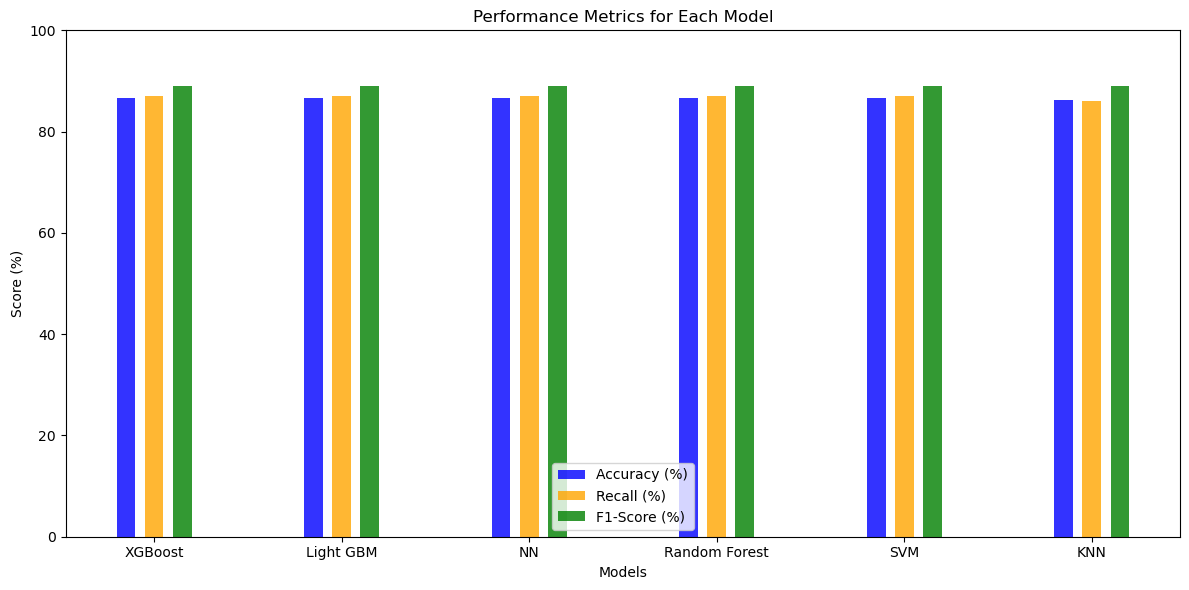

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['XGBoost', 'Light GBM', 'NN', 'Random Forest', 'SVM', 'KNN']
metrics = ['Accuracy (%)', 'Recall (%)', 'F1-Score (%)']
values = np.array([
    [86.7, 86.7, 86.7, 86.7, 86.7, 86.3],
    [87, 87, 87, 87, 87 ,86],
    [89, 89, 89, 89, 89, 89]
])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1  # thinner bars
opacity = 0.8
space = 0.05  # space between the bars
colors = ['blue', 'orange', 'green']  # Blue, orange, green

for i, metric in enumerate(metrics):
    rects = ax.bar(np.arange(len(models)) + (i * (bar_width + space)), values[i], bar_width,
                   alpha=opacity, color=colors[i], label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score (%)')
ax.set_title('Performance Metrics for Each Model')
ax.set_xticks(np.arange(len(models)) + ((len(metrics) - 1) * (bar_width + space)) / 2)  # Center x-ticks
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100
ax.legend()

plt.tight_layout()
plt.savefig('Evaluation_Metrics_all_LocDist.svg', format='svg')
plt.show()


**Combined Confusion matrix**

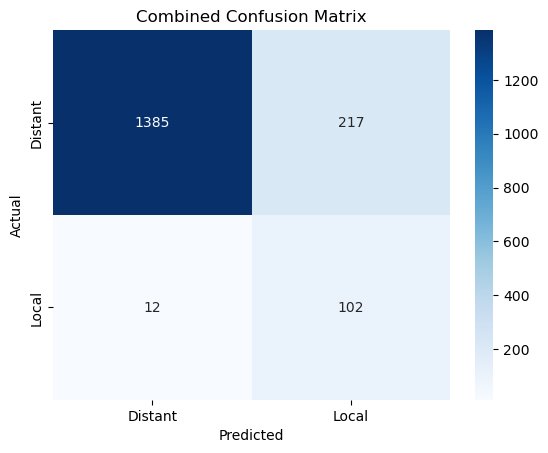

In [ ]:
# Confusion matrices for each model
conf_matrix_rf = np.array([[231, 36],
                            [2, 17]])

conf_matrix_xgboost = np.array([[231, 36],
                                 [2, 17]])

conf_matrix_svm = np.array([[231, 36],
                             [2, 17]])

conf_matrix_knn = np.array([[230, 37],
                             [2, 17]])

conf_matrix_nn = np.array([[231, 36],
                            [2, 17]])

conf_matrix_lgbm = np.array([[231, 36],
                            [2, 17]])


# Sum up corresponding cells
combined_conf_matrix = conf_matrix_rf + conf_matrix_xgboost + conf_matrix_svm + conf_matrix_knn + conf_matrix_nn + conf_matrix_lgbm

# Plotting
class_labels = ['Distant', 'Local']
sns.heatmap(combined_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix')
plt.savefig('Combined CM_LocDist.svg', format='svg')
plt.show()

___________________________________________________________________________________________________________________________________________________________

# **Make comparison between local & distant types in baheya and our data**

In [ ]:
# merged data
local_df = balanced_data[balanced_data['Recurrence_Type'] == 'Local']
distant_df = balanced_data[balanced_data['Recurrence_Type'] == 'Distant']

specified_sample_size = 19

sample_size = min(specified_sample_size, len(local_df), len(distant_df))

local_sample = local_df.sample(n=sample_size, random_state=1)
distant_sample = distant_df.sample(n=sample_size, random_state=1)

sampled_df = pd.concat([local_sample, distant_sample])

sampled_df = sampled_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
# Baheya data
local_df_b = Baheya_data[Baheya_data['Recurrence_Type'] == 'Local']
distant_df_b = Baheya_data[Baheya_data['Recurrence_Type'] == 'Distant']


specified_sample_size = 19

sample_size_b = min(specified_sample_size, len(local_df), len(distant_df))

local_sample_b = local_df_b.sample(n=sample_size_b, random_state=1)
distant_sample_b = distant_df_b.sample(n=sample_size_b, random_state=1)

sampled_df_b = pd.concat([local_sample_b, distant_sample_b])

sampled_df_b = sampled_df_b.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
sampled_df_b['Recurrence_Type'].value_counts()

Recurrence_Type
Local      19
Distant    19
Name: count, dtype: int64

In [ ]:
sampled_df.columns

Index(['Tumor Size', 'Recurrence_Type', 'Lymph Node Status', 'Tumor Grade',
       'Mol Subtype', 'ER', 'HER2'],
      dtype='object')

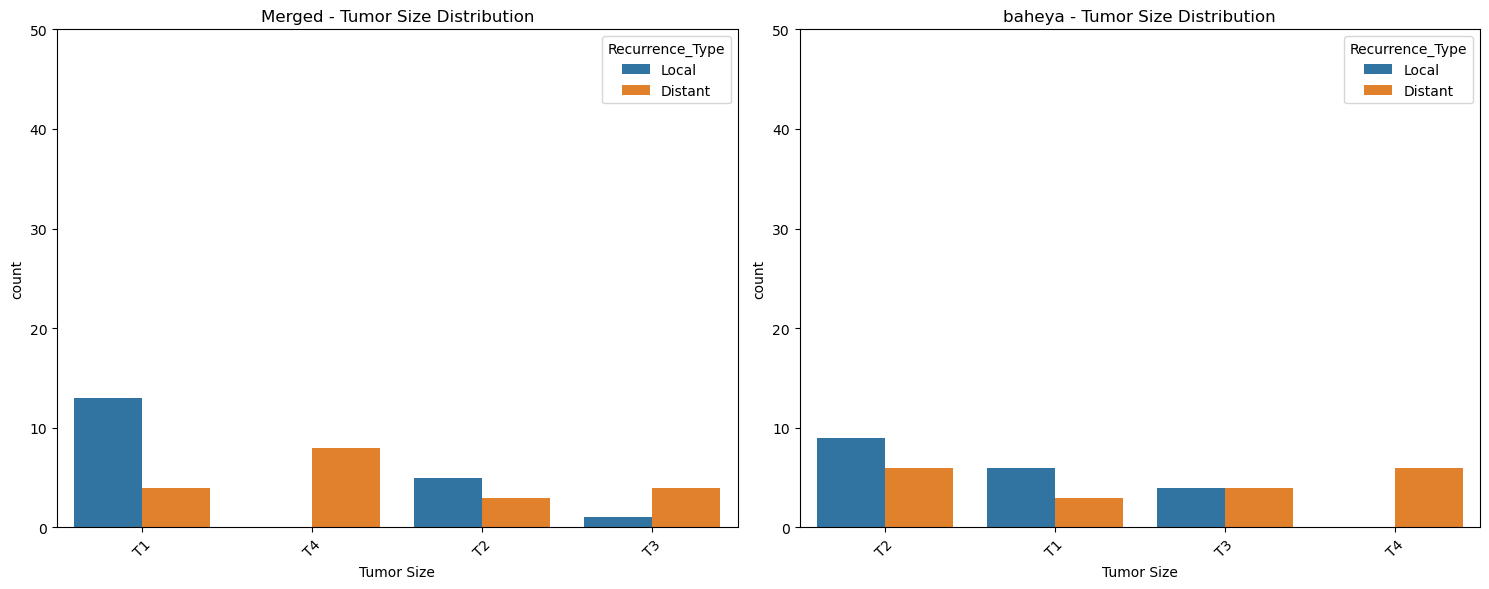

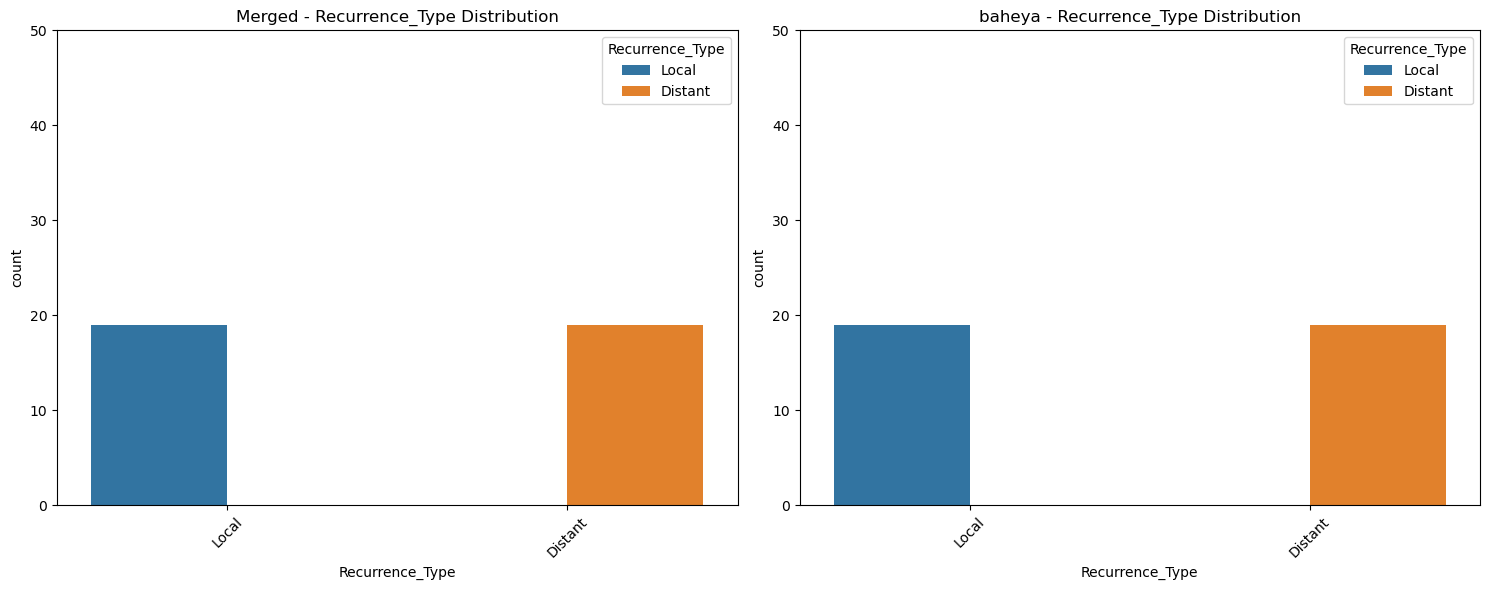

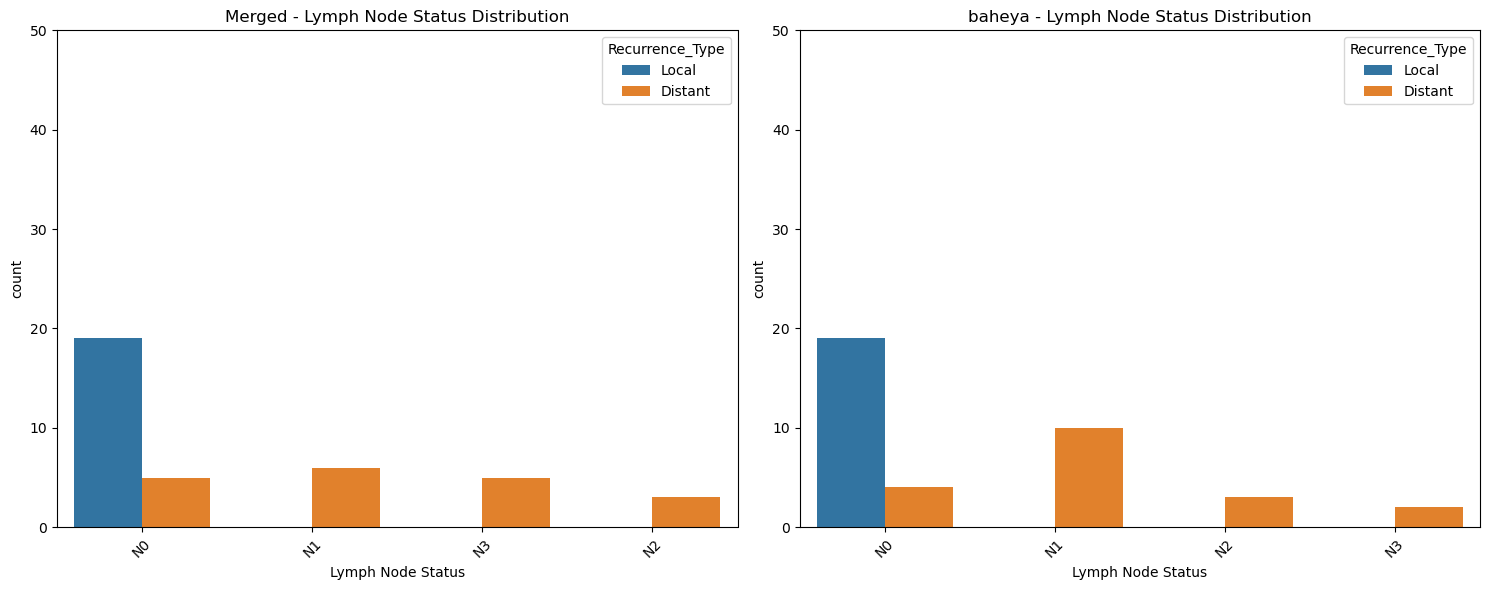

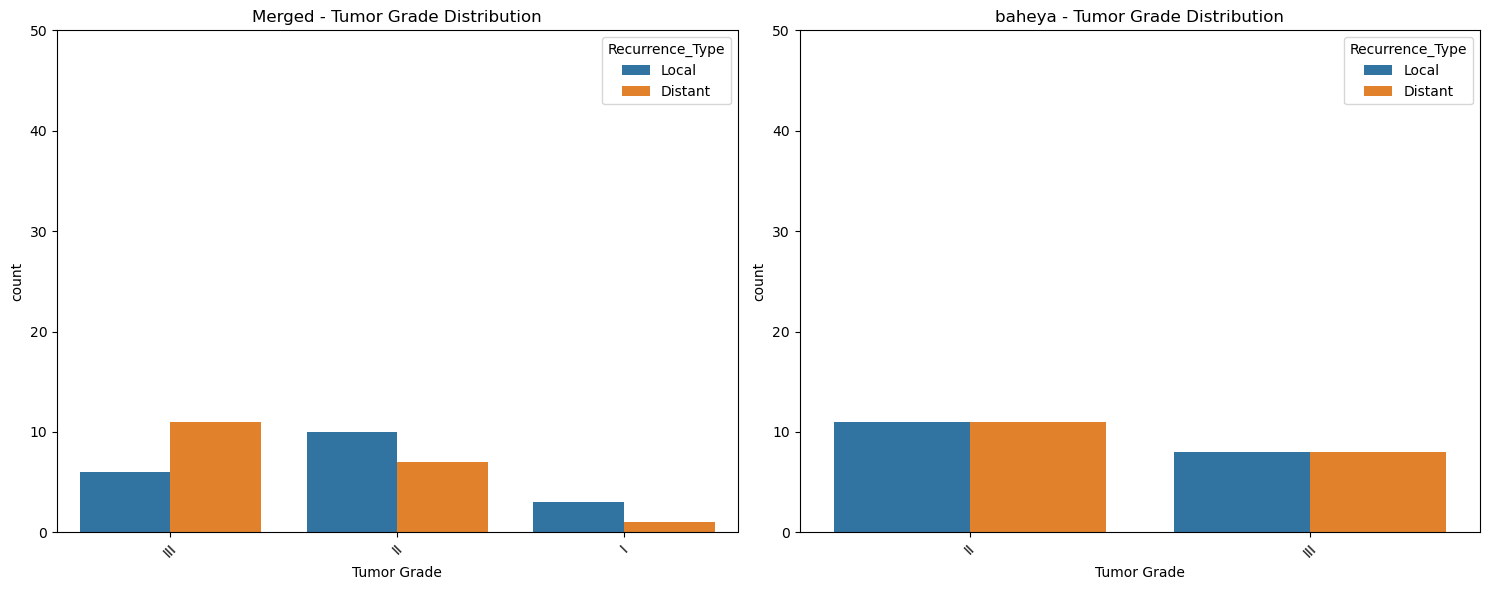

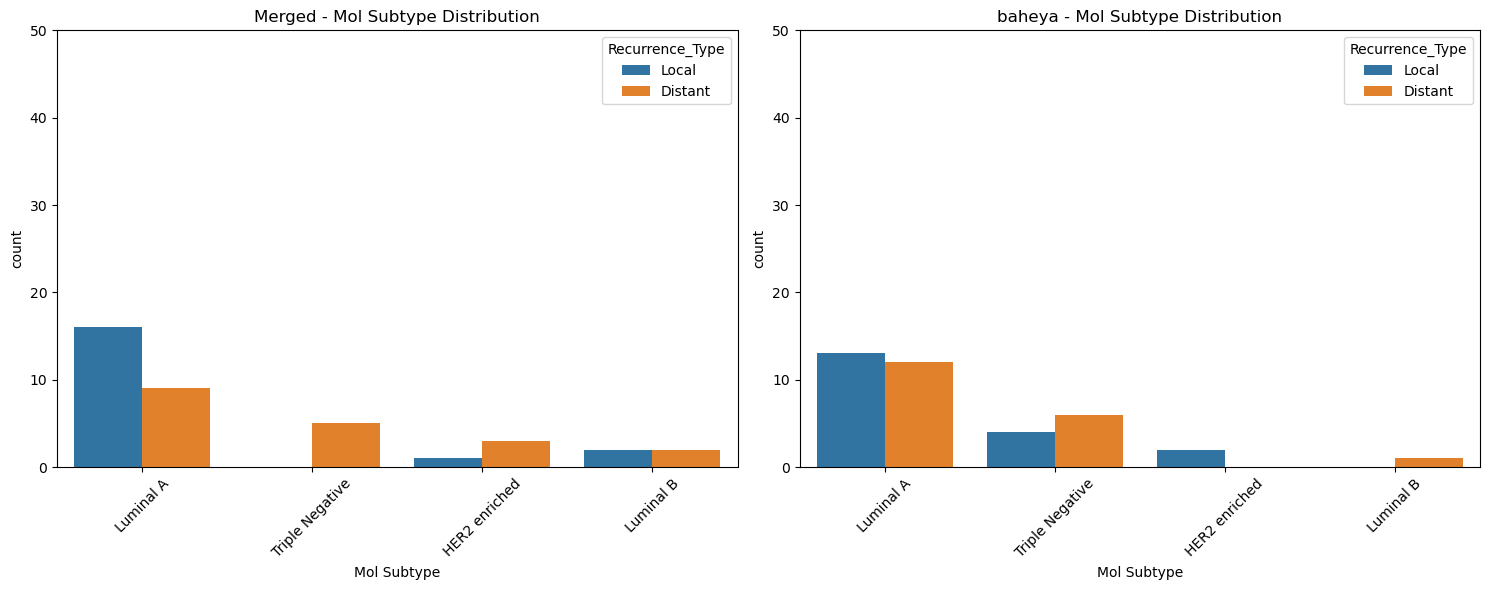

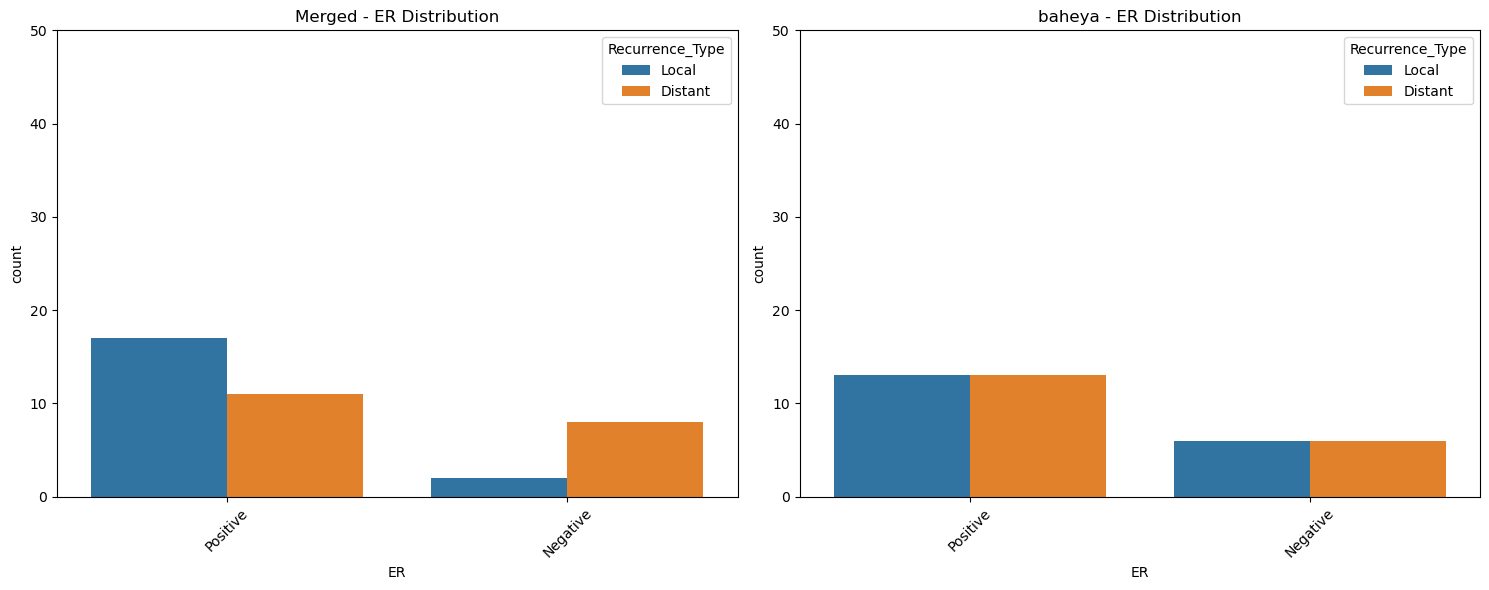

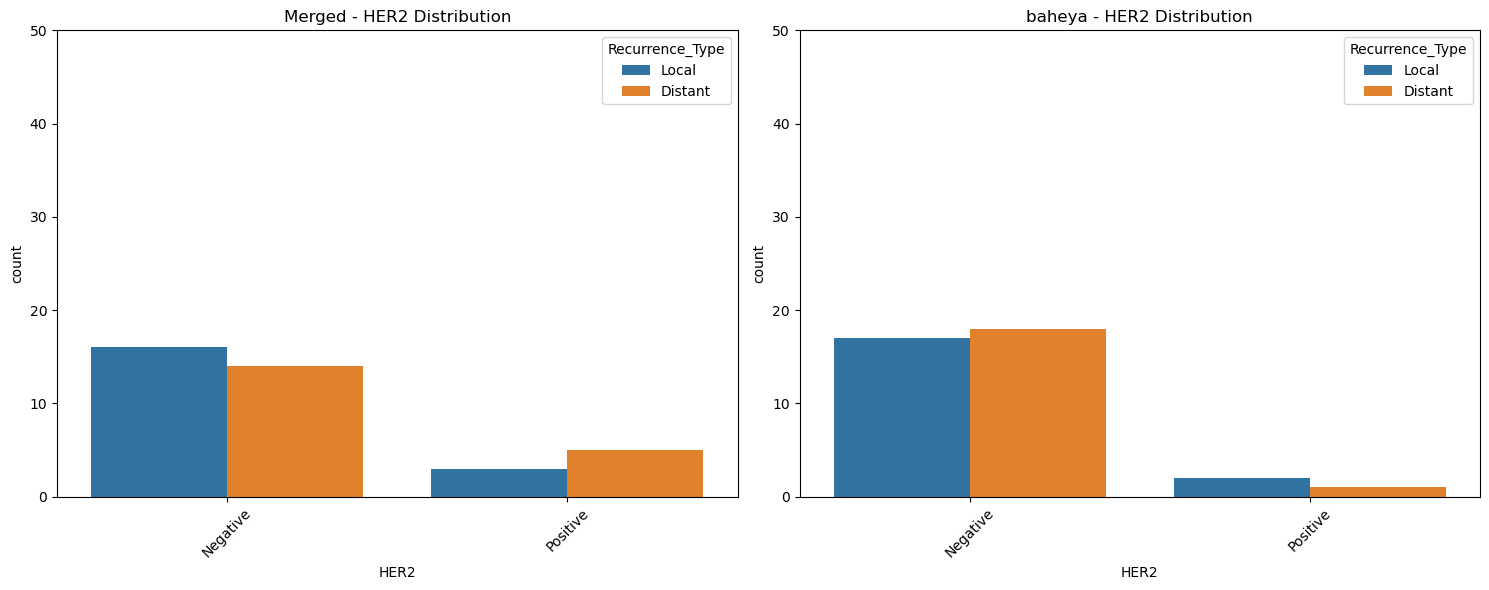

In [ ]:
for column in sampled_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots with 1 row and 2 columns

    # Plot for the merged dataset
    sns.countplot(data=sampled_df, x=column, order=sampled_df[column].value_counts().index, hue='Recurrence_Type', ax=axes[0])
    axes[0].set_title(f'Merged - {column} Distribution')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 50)  # Set y-axis range from 0 to 100

    # Plot for the baheya dataset
    sns.countplot(data=sampled_df_b, x=column, order=sampled_df_b[column].value_counts().index, hue='Recurrence_Type', ax=axes[1])
    axes[1].set_title(f'baheya - {column} Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylim(0, 50)  # Set y-axis range from 0 to 100

    plt.tight_layout()

    # Save the figure as an SVG file with the feature name in the filename
    filename = f'{column}_distribution.svg'
    plt.savefig(filename, format='svg')

    plt.show()
